In [1]:
from datetime import datetime

# SecureString parameter stored in AWS System Manager that holds a GitHub personal access token.
parameter_name = 'github_token'

# Repositories for which reports will be generated.
repo_names = [
    # Android
    'aws-amplify/amplify-android',
    'aws-amplify/aws-sdk-android',
    'awslabs/aws-mobile-appsync-sdk-android',

    # iOS
    'aws-amplify/amplify-ios',
    'aws-amplify/aws-sdk-ios',
    'awslabs/aws-mobile-appsync-sdk-ios',
    
    # JS
    'aws-amplify/amplify-js',
    
    # CLI
    'aws-amplify/amplify-cli',
    
    # Docs
    'aws-amplify/docs'
]

# Labels used across different repositories
issue_buckets = {
    'Bug': ['Bug', 'bug'],
    'Feature Request': ['Improvement', 'Feature Request', 'enhancement', 'feature-request'],
    'Question': ['Usage Question', 'Question', 'question'],
    'Pending Triage': ['Pending Triage', 'to-be-reproduced']
}

# Labels to omit from rows
omit_labels = {
    'Wont Fix', "Won't Fix", 'closing-soon-if-no-response', 'Product Review',
    'Requesting Feedback', 'Closing Soon', 'Clarification Needed', 'Duplicate',
    'Needs Info from Requester', 'work-in-progress', 'good-first-issue',
    'pending-close-response-required', 'pending-response', 'pending-release',
    'Awaiting Release', 'Investigating', 'Pending', 'Pull Request', 'duplicate',
    'good first issue', 'Reviewing', 'needs review', 'needs discussion',
    'needs-review', 'investigating', 'help wanted', 'needs-discussion',
    'Help Wanted', 'Good First Issue', 'wontfix'
}
omit_labels = omit_labels.union({label for labels in issue_buckets.values() for label in labels})

# Capture start time
start = datetime.now()

In [2]:
# Retrieve the GitHub token from SSM to prevent oops-I-pushed-credentials-to-GitHub uh-ohs.

import boto3

ssm = boto3.client('ssm')
response = ssm.get_parameter(Name=parameter_name, WithDecryption=True)
token = response['Parameter']['Value']

In [3]:
# Grab all issues from the GitHub V4 GraphQL API

import requests
import json

headers = {'Authorization': f'Bearer {token}'}


def get_issues(owner, name, *, end_cursor=None):
    query = """
    query($owner: String!, $name: String!, $endCursor: String) {
      repository(owner:$owner, name:$name) {
        issues(first:100, after:$endCursor) {
          nodes {
            number
            title
            createdAt
            closedAt
            reactions {
              totalCount
            }
            comments(first:100) {
              nodes {
                createdAt
                author {
                  login
                }
                reactions {
                  totalCount
                }
              }
            }
            labels(first:3) {
              nodes {
                name
              }
            }
          }
          pageInfo {
            hasNextPage
            endCursor
          }
        }
      }
    }"""
    
    variables = {'owner': owner, 'name': name, 'endCursor': end_cursor}
    response = execute(query, variables)
    page_info = response['data']['repository']['issues']['pageInfo']
    nodes = response['data']['repository']['issues']['nodes']
    
    for issue in nodes:
        yield issue
    
    if page_info['hasNextPage']:
        yield from get_issues(owner, name, end_cursor=page_info['endCursor'])
    
def execute(query, variables):
    request = requests.post(
        'https://api.github.com/graphql',
        json={'query': query, 'variables': variables},
        headers=headers
    )

    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("{}: {}".format(request.status_code, query))

In [5]:
# Loop through each repository, grab all issues, and create a DataFrame for each.

import pandas as pd

repos = {}
bucket_lookup = {label: bucket for bucket, labels in issue_buckets.items() for label in labels}

for repo_name in repo_names:
    issues = []
    owner, name = repo_name.split('/')

    for issue in get_issues(owner, name):
        labels = pd.array([label['name'] for label in issue['labels']['nodes']])
        bucket = 'Other'
        created_at = pd.Timestamp(issue['createdAt'],tz='UTC')
        
        score = 1
        score += len(issue['comments']['nodes'])
        score += issue['reactions']['totalCount']
        score += sum(comment['reactions']['totalCount'] for comment in issue['comments']['nodes'])
        
        if issue['closedAt']:
            closed_at = pd.Timestamp(issue['closedAt'], tz='UTC')
        else:
            closed_at = None
            
        for label in labels:
            if label in bucket_lookup:
                bucket = bucket_lookup[label]
                break
                
        issues.append(
            [issue['number'], issue['title'], labels, created_at, closed_at, bucket, score]
        )
        
    repos[repo_name] = pd.DataFrame(issues, columns=[
        'id', 'title', 'labels', 'created_at', 'closed_at', 'bucket', 'score'
    ])

In [6]:
# Utility function to generate statistics (counts, MoM, WoW, etc) for a DataFrame.

import pytz
from datetime import datetime


def generate_stats(df):
    utc = pytz.timezone('UTC')

    seven_days_ago = datetime.now() - pd.Timedelta('7 days')
    seven_days_ago = seven_days_ago.astimezone(utc)

    thirty_days_ago = datetime.now() - pd.Timedelta('30 days')
    thirty_days_ago = thirty_days_ago.astimezone(utc)

    open_issues = df[~(df.closed_at > '1970-01-01')]
    last_week_closed_issues = df[(df.closed_at > seven_days_ago)]
    last_month_closed_issues = df[(df.closed_at > thirty_days_ago)]
    last_week_open_issues = df[(df.created_at < seven_days_ago) & ~(df.closed_at < seven_days_ago)]
    last_month_open_issues = df[(df.created_at < thirty_days_ago) & ~(df.closed_at < thirty_days_ago)]
    
    open_issues_count = len(open_issues.index)
    last_week_closed_issues_count = len(last_week_closed_issues.index)
    last_month_closed_issues_count = len(last_month_closed_issues.index)
    last_week_open_issues_count = len(last_week_open_issues.index)
    last_month_open_issues_count = len(last_month_open_issues.index)
    
    return [
        open_issues_count,
        last_week_open_issues_count,
        open_issues_count - last_week_open_issues_count,
        last_month_open_issues_count,
        open_issues_count - last_month_open_issues_count,
        last_week_closed_issues_count,
        last_month_closed_issues_count
    ]

In [7]:
# Using the DataFrames, process and grab the counts of issues by repo and then by bucket.

import pandas as pd
from IPython.display import display, HTML

pd.set_option('display.max_rows', 500)

for repo_name in repo_names:
    df = repos[repo_name]
    buckets = {bucket for bucket in df.bucket}
    
    row = [repo_name]
    row.extend(generate_stats(df))

    open_df = pd.DataFrame([row], columns=[
        'Repo', 'Open', 'Last Week', 'WoW', 'Last Month', 'MoM', 'Closed Last Week',
        'Closed Last Month'
    ])
    
    display(HTML(f'<h1>{repo_name}</h1>'))
    display(open_df)
    
    for bucket in sorted(buckets):
        bucket_counts = []
        issues = df.loc[df.bucket == bucket]
        labels = {label for labels in issues.labels for label in labels}
        row = [bucket, '']

        row.extend(generate_stats(issues))
        bucket_counts.append(row)
        
        for label in sorted(labels):
            if label in omit_labels or label in buckets:
                continue
            
            label_mask = issues.labels.apply(lambda l: label in l)
            label_issues = issues[label_mask]
            stats = generate_stats(label_issues)
            
            if sum(stats): 
                row = [bucket, label]
                row.extend(stats)
                bucket_counts.append(row)

        bucket_df = pd.DataFrame(bucket_counts, columns=[
            'Bucket', 'Label', 'Open', 'Last Week', 'WoW', 'Last Month', 'MoM',
            'Closed Last Week', 'Closed Last Month'
        ])
        
        display(HTML(f'<h2>{repo_name}: {bucket}'))
        display(bucket_df)

    display(HTML(f'<hr>'))

,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-android,34,29,5,30,4,3,24


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,13,13,0,16,-3,1,14
1,Bug,API,3,3,0,1,2,0,2
2,Bug,Amplify Gradle Plugin,1,1,0,1,0,0,1
3,Bug,Auth,3,2,1,1,2,0,1
4,Bug,DataStore,6,7,-1,13,-7,1,10


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,13,12,1,11,2,0,4
1,Feature Request,API,4,4,0,4,0,0,1
2,Feature Request,Amplify Gradle Plugin,1,1,0,1,0,0,0
3,Feature Request,Auth,3,2,1,0,3,0,0
4,Feature Request,Core,1,1,0,1,0,0,0
5,Feature Request,DataStore,1,1,0,1,0,0,1
6,Feature Request,Predictions,1,1,0,1,0,0,0
7,Feature Request,RFC,1,0,1,0,1,0,0
8,Feature Request,Storage,2,2,0,1,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,5,2,3,3,2,0,4
1,Other,Auth,0,0,0,1,-1,0,1
2,Other,DataStore,1,1,0,0,1,0,0
3,Other,RFC,2,1,1,1,1,0,0
4,Other,Storage,1,0,1,0,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,2,1,1,0,2,0,0
1,Pending Triage,Auth,2,1,1,0,2,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,1,1,0,0,1,2,2
1,Question,API,1,1,0,0,1,0,0
2,Question,Auth,0,0,0,0,0,2,2


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/aws-sdk-android,150,150,0,153,-3,3,14


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,35,36,-1,34,1,2,3
1,Bug,AWSMobileClient,8,9,-1,8,0,1,2
2,Bug,AppSync,1,1,0,1,0,0,0
3,Bug,Cognito,5,5,0,5,0,0,0
4,Bug,Core,2,2,0,2,0,0,0
5,Bug,IoT,3,3,0,2,1,0,0
6,Bug,KinesisVideo,2,2,0,2,0,0,0
7,Bug,Lambda,3,3,0,3,0,0,0
8,Bug,Pinpoint,3,3,0,3,0,0,0
9,Bug,S3,6,6,0,6,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,65,64,1,65,0,0,1
1,Feature Request,APIGateway,1,1,0,1,0,0,0
2,Feature Request,AWSMobileClient,16,16,0,16,0,0,0
3,Feature Request,Cognito,14,14,0,15,-1,0,1
4,Feature Request,Core,5,5,0,5,0,0,0
5,Feature Request,Documentation,1,1,0,1,0,0,0
6,Feature Request,IoT,12,11,1,11,1,0,0
7,Feature Request,KinesisVideo,1,1,0,1,0,0,0
8,Feature Request,Lambda,1,1,0,1,0,0,0
9,Feature Request,Other AWS Services,3,3,0,3,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,16,15,1,19,-3,0,8
1,Other,AWSMobileClient,8,8,0,9,-1,0,2
2,Other,Cognito,3,3,0,3,0,0,0
3,Other,Connect,0,0,0,1,-1,0,1
4,Other,Core,0,0,0,1,-1,0,1
5,Other,DynamoDB,1,1,0,1,0,0,0
6,Other,IoT,1,1,0,1,0,0,0
7,Other,Lex,0,0,0,1,-1,0,1
8,Other,Sample App,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,7,7,0,8,-1,0,1
1,Pending Triage,AWSMobileClient,4,4,0,4,0,0,0
2,Pending Triage,IoT,0,0,0,1,-1,0,1
3,Pending Triage,S3,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,27,28,-1,27,0,1,1
1,Question,APIGateway,3,3,0,3,0,0,0
2,Question,AWSMobileClient,11,12,-1,11,0,1,1
3,Question,Cognito,5,5,0,5,0,0,0
4,Question,Core,2,2,0,2,0,0,0
5,Question,Documentation,1,1,0,1,0,0,0
6,Question,IoT,2,2,0,2,0,0,0
7,Question,KinesisVideo,1,1,0,1,0,0,0
8,Question,Pinpoint,2,2,0,2,0,0,0
9,Question,S3,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,awslabs/aws-mobile-appsync-sdk-android,52,52,0,52,0,2,3


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,20,20,0,20,0,0,0
1,Bug,AppSync,19,19,0,19,0,0,0
2,Bug,Codegen,2,2,0,2,0,0,0
3,Bug,Documentation,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,14,14,0,14,0,0,0
1,Feature Request,AppSync,13,13,0,13,0,0,0
2,Feature Request,Codegen,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,9,9,0,9,0,2,3
1,Other,AppSync,2,2,0,2,0,0,0
2,Other,Codegen,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,9,9,0,9,0,0,0
1,Question,AppSync,9,9,0,9,0,0,0
2,Question,Documentation,1,1,0,1,0,0,0
3,Question,Infrastructure,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-ios,80,77,3,81,-1,4,44


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,14,15,-1,18,-4,2,13
1,Bug,api,4,3,1,1,3,0,0
2,Bug,auth,1,1,0,2,-1,0,5
3,Bug,build,1,1,0,1,0,0,0
4,Bug,datastore,9,11,-2,13,-4,2,7
5,Bug,documentation,0,0,0,1,-1,0,1
6,Bug,follow up,3,4,-1,3,0,1,1
7,Bug,pending investigation,1,1,0,1,0,0,0
8,Bug,pending release,1,0,1,1,0,0,5
9,Bug,pending triage,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,27,27,0,24,3,0,2
1,Feature Request,analytics,2,2,0,2,0,0,0
2,Feature Request,api,7,7,0,5,2,0,1
3,Feature Request,auth,2,2,0,1,1,0,0
4,Feature Request,core,4,4,0,3,1,0,0
5,Feature Request,datastore,14,14,0,13,1,0,0
6,Feature Request,documentation,1,1,0,1,0,0,1
7,Feature Request,feature request,1,1,0,0,1,0,0
8,Feature Request,pending investigation,2,2,0,1,1,0,0
9,Feature Request,pending release,1,1,0,1,0,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,39,35,4,39,0,2,29
1,Other,analytics,1,1,0,1,0,0,1
2,Other,api,12,11,1,8,4,1,5
3,Other,auth,5,5,0,4,1,1,8
4,Other,build,3,3,0,3,0,0,1
5,Other,closing soon,2,2,0,12,-10,0,11
6,Other,contribution,1,1,0,0,1,0,0
7,Other,core,4,4,0,4,0,0,1
8,Other,datastore,15,15,0,16,-1,0,4
9,Other,documentation,6,6,0,6,0,0,2


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/aws-sdk-ios,206,200,6,203,3,0,16


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,40,39,1,40,0,0,4
1,Bug,APIGateway,1,1,0,1,0,0,0
2,Bug,AWSMobileClient,7,6,1,7,0,0,2
3,Bug,AppSync,2,2,0,2,0,0,0
4,Bug,Build,1,1,0,1,0,0,1
5,Bug,Cognito,3,3,0,3,0,0,0
6,Bug,Core,1,1,0,1,0,0,0
7,Bug,Documentation,1,1,0,1,0,0,0
8,Bug,IoT,12,12,0,12,0,0,0
9,Bug,Pinpoint,4,4,0,5,-1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,87,87,0,87,0,0,1
1,Feature Request,APIGateway,4,4,0,4,0,0,0
2,Feature Request,AWSMobileClient,23,23,0,23,0,0,0
3,Feature Request,Build,2,2,0,2,0,0,0
4,Feature Request,Cognito,21,21,0,21,0,0,1
5,Feature Request,Core,1,1,0,1,0,0,0
6,Feature Request,Documentation,1,1,0,1,0,0,0
7,Feature Request,DynamoDB,1,1,0,1,0,0,0
8,Feature Request,Infrastructure,2,2,0,2,0,0,0
9,Feature Request,IoT,8,8,0,8,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,40,36,4,39,1,0,6
1,Other,APIGateway,1,1,0,1,0,0,0
2,Other,AWSMobileClient,7,7,0,7,0,0,1
3,Other,AppSync,1,1,0,1,0,0,0
4,Other,Build,3,3,0,4,-1,0,1
5,Other,Cognito,12,12,0,12,0,0,0
6,Other,Core,1,1,0,1,0,0,0
7,Other,FrameworkBuild,0,0,0,1,-1,0,1
8,Other,Infrastructure,1,1,0,1,0,0,0
9,Other,IoT,3,3,0,3,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,39,38,1,37,2,0,5
1,Question,APIGateway,2,2,0,2,0,0,0
2,Question,AWSMobileClient,4,3,1,3,1,0,0
3,Question,AppSync,1,1,0,1,0,0,0
4,Question,Cognito,10,10,0,10,0,0,0
5,Question,Core,1,1,0,1,0,0,0
6,Question,Documentation,1,1,0,1,0,0,0
7,Question,FrameworkBuild,1,1,0,1,0,0,0
8,Question,IoT,3,3,0,3,0,0,0
9,Question,KMS,1,1,0,0,1,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,awslabs/aws-mobile-appsync-sdk-ios,65,68,-3,66,-1,3,5


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,21,23,-2,21,0,2,2
1,Bug,AppSync,20,20,0,19,1,0,0
2,Bug,Documentation,1,1,0,1,0,0,0
3,Bug,Service,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,21,21,0,21,0,0,0
1,Feature Request,AppSync,19,19,0,19,0,0,0
2,Feature Request,Build,1,1,0,1,0,0,0
3,Feature Request,Documentation,3,3,0,3,0,0,0
4,Feature Request,Infrastructure,1,1,0,1,0,0,0
5,Feature Request,tvOS,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,9,9,0,8,1,0,1
1,Other,AppSync,7,7,0,7,0,0,0
2,Other,Build,1,1,0,1,0,0,0
3,Other,Documentation,1,1,0,0,1,0,0
4,Other,Tests,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,14,15,-1,16,-2,1,2
1,Question,AppSync,12,12,0,12,0,0,0
2,Question,Build,1,1,0,1,0,0,0
3,Question,Documentation,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-js,628,631,-3,605,23,27,96


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,34,33,1,36,-2,0,8
1,Bug,API,0,0,0,1,-1,0,1
2,Bug,Amplify UI Components,3,2,1,3,0,0,2
3,Bug,Analytics,0,0,0,1,-1,0,1
4,Bug,Angular,3,3,0,2,1,0,0
5,Bug,Auth,7,7,0,7,0,0,2
6,Bug,Browser Compatibly,2,2,0,2,0,0,0
7,Bug,Cognito,8,8,0,8,0,0,0
8,Bug,Core,1,1,0,0,1,0,0
9,Bug,DataStore,6,6,0,7,-1,0,2


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,381,376,5,359,22,2,10
1,Feature Request,API,16,16,0,13,3,0,0
2,Feature Request,Amplify UI Components,27,25,2,24,3,0,2
3,Feature Request,Analytics,14,14,0,12,2,0,0
4,Feature Request,Angular,14,14,0,14,0,0,0
5,Feature Request,AppSync,6,6,0,6,0,0,0
6,Feature Request,Auth,84,84,0,79,5,0,0
7,Feature Request,Build,3,3,0,3,0,0,0
8,Feature Request,Caching,1,1,0,1,0,0,0
9,Feature Request,Cognito,53,52,1,51,2,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,68,77,-9,86,-18,13,41
1,Other,API,5,5,0,9,-4,0,5
2,Other,Amplify UI Components,8,9,-1,7,1,2,5
3,Other,Analytics,1,1,0,3,-2,0,2
4,Other,Angular,2,2,0,2,0,0,0
5,Other,AppSync,4,4,0,5,-1,0,1
6,Other,Auth,31,32,-1,34,-3,3,12
7,Other,Can't reproduce,3,4,-1,6,-3,2,4
8,Other,Cognito,20,20,0,20,0,0,2
9,Other,DataStore,2,2,0,2,0,1,2


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,95,90,5,73,22,5,27
1,Pending Triage,API,2,3,-1,1,1,1,1
2,Pending Triage,Analytics,5,5,0,5,0,0,0
3,Pending Triage,Angular,3,3,0,3,0,0,0
4,Pending Triage,AppSync,1,1,0,1,0,0,0
5,Pending Triage,Auth,38,37,1,29,9,2,7
6,Pending Triage,Build,2,2,0,2,0,0,0
7,Pending Triage,Cognito,3,2,1,2,1,0,0
8,Pending Triage,Core,1,1,0,1,0,0,0
9,Pending Triage,DataStore,16,14,2,14,2,0,3


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,50,55,-5,51,-1,7,10
1,Question,API,2,2,0,2,0,0,0
2,Question,Analytics,1,1,0,1,0,0,0
3,Question,Angular,5,5,0,4,1,0,0
4,Question,AppSync,5,6,-1,6,-1,1,1
5,Question,Auth,23,25,-2,22,1,4,4
6,Question,Cognito,6,6,0,6,0,0,1
7,Question,DataStore,3,3,0,3,0,0,1
8,Question,GraphQL,4,4,0,4,0,0,0
9,Question,OAuth,0,0,0,0,0,1,1


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-cli,734,723,11,663,71,29,116


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,90,93,-3,78,12,6,17
1,Bug,@auth,4,4,0,3,1,0,0
2,Bug,@key,3,3,0,3,0,0,0
3,Bug,DataStore,2,1,1,1,1,0,0
4,Bug,Lambda layers,1,1,0,0,1,0,0
5,Bug,amplify-app,1,1,0,1,0,0,0
6,Bug,amplify-console,1,1,0,0,1,0,0
7,Bug,analytics,0,0,0,0,0,0,1
8,Bug,aurora,1,1,0,1,0,0,0
9,Bug,auth,5,5,0,5,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,499,496,3,469,30,3,8
1,Feature Request,@auth,6,6,0,6,0,0,0
2,Feature Request,@connection,1,1,0,1,0,0,0
3,Feature Request,@key,7,7,0,7,0,0,1
4,Feature Request,@model,1,1,0,1,0,0,0
5,Feature Request,@searchable,6,6,0,6,0,0,0
6,Feature Request,DataStore,9,9,0,8,1,0,0
7,Feature Request,Lambda layers,1,1,0,0,1,0,1
8,Feature Request,REST API,15,15,0,13,2,0,0
9,Feature Request,RFC,5,5,0,5,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,110,97,13,76,34,18,62
1,Other,@auth,5,5,0,2,3,0,1
2,Other,@connection,1,1,0,0,1,0,0
3,Other,@key,1,2,-1,2,-1,1,1
4,Other,@searchable,4,3,1,3,1,0,1
5,Other,DataStore,1,1,0,1,0,0,0
6,Other,Lambda layers,1,1,0,0,1,1,2
7,Other,REST API,2,1,1,2,0,0,1
8,Other,RFC,5,5,0,6,-1,0,1
9,Other,amplify-console,1,1,0,0,1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,35,37,-2,40,-5,2,29
1,Question,@auth,4,4,0,3,1,0,1
2,Question,@key,1,1,0,2,-1,0,1
3,Question,DataStore,3,3,0,3,0,0,0
4,Question,REST API,0,0,0,1,-1,0,1
5,Question,analytics,1,1,0,1,0,0,0
6,Question,aurora,1,1,0,0,1,0,0
7,Question,auth,3,3,0,4,-1,0,1
8,Question,cloudformation,1,1,0,1,0,0,1
9,Question,functions,3,3,0,3,0,0,2


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/docs,76,76,0,70,6,9,42


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,1,1,0,1,0,0,0
1,Bug,CLI,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,12,12,0,9,3,0,0
1,Feature Request,CLI,3,3,0,3,0,0,0
2,Feature Request,JavaScript,3,3,0,2,1,0,0
3,Feature Request,documentation site,3,3,0,3,0,0,0
4,Feature Request,iOS,1,1,0,0,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,63,63,0,60,3,9,42
1,Other,Android,1,1,0,2,-1,0,4
2,Other,CLI,10,10,0,13,-3,1,7
3,Other,JavaScript,30,32,-2,27,3,2,14
4,Other,UI,6,6,0,5,1,1,1
5,Other,documentation site,2,2,0,1,1,0,1
6,Other,iOS,4,4,0,6,-2,0,4
7,Other,pending-close-if-no-response,6,7,-1,8,-2,1,4
8,Other,v2,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,0,0,0,0,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,0,0,0,0,0,0,0


In [8]:
##### Top Open Bugs by Activity

from IPython.core.display import HTML

pd.set_option('display.max_colwidth', None)

display(HTML(f'<h1>Top Open Bugs by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Bug']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(5))

# Top Open Feature Requests by Activity

display(HTML(f'<h1>Top Open Feature Requests by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Feature Request']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)
    
    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(5))

,id,title,created_at,labels,score
79,552,Sign in with web UI failed,2020-06-04 09:11:09+00:00,"[Auth, Bug]",23
100,595,"""E/SQLiteLog: (1) no such table: "" occurs when I use ""Amplify.DataStore.save()""",2020-06-24 05:59:06+00:00,"[Bug, DataStore]",15
64,464,Synchronization Error with relations,2020-05-14 20:46:43+00:00,"[Bug, DataStore]",10
68,487,DataStore multiple one has many relation error,2020-05-19 14:46:42+00:00,"[Bug, DataStore]",8
113,634,Amplify.signInWithWebUI not prompting login page for new user after calling Amplify.signOut,2020-07-10 16:29:16+00:00,"[Auth, Bug]",8


,id,title,created_at,labels,score
801,1259,AWSIotMqttManager NoClassDefFoundError with Android < 7,2019-10-16 19:36:15+00:00,"[Bug, IoT]",51
895,1507,Logged out after changing permission,2020-03-06 09:29:30+00:00,"[Bug, Core, Pending Triage]",26
695,1003,AWSMobileClient.getInstance().showSignIn() buttons do not work after sign-out or invalid token,2019-06-02 04:34:37+00:00,"[AWSMobileClient, Bug]",19
680,956,Sign in issue in AmazonKinesisVideoDemoApp,2019-05-13 21:40:47+00:00,"[AWSMobileClient, Bug]",15
803,1264,NullPointerException Attempt to invoke virtual method 'java.lang.String com.amazonaws.services.cognitoidentityprovider.model.CodeDeliveryDetailsType.getDestination()' on a null object reference,2019-10-21 12:43:01+00:00,"[AWSMobileClient, Bug]",14


,id,title,created_at,labels,score
146,246,"Subscription initialization throws ""Invalid message type string"" exception when token has expired",2020-01-15 15:23:59+00:00,"[AppSync, Bug]",12
150,257,Subscriptions don't work in 3.0.x; NullPointerException on AWSConfiguration object,2020-02-04 08:58:26+00:00,"[AppSync, Bug]",10
122,206,Disabling cache not working in Appsync / appollo,2019-07-18 21:06:12+00:00,"[AppSync, Bug]",8
123,207,Delta sync base query always runs again after process restart,2019-07-23 06:08:10+00:00,"[AppSync, Bug]",8
86,136,IOException/SocketTimeoutException not propagated to GraphQLCall.Callback and Appsync goes into a long loop of retrying,2019-03-26 18:42:58+00:00,"[AppSync, Bug]",7


,id,title,created_at,labels,score
195,591,API: Error deserializing from error response,2020-06-28 21:10:50+00:00,"[bug, datastore, requesting info]",15
155,507,"Error: ""The key __typename was not found"" when using DataStore with existing data in database.",2020-06-02 15:30:51+00:00,"[bug, datastore, follow up]",13
223,641,Amplify Predictions identify not returning form(keyValue) and table data,2020-07-14 06:43:53+00:00,"[bug, predictions]",11
154,505,Incorrect codegen error - DataStore does not support 1 to 1 connection with both sides of connection as optional field,2020-06-01 16:24:46+00:00,"[bug, datastore]",8
153,504,Codegen produces compile error - Value type 'PhoneCall' cannot have a stored property that recursively contains it,2020-06-01 16:14:23+00:00,"[bug, datastore, follow up]",6


,id,title,created_at,labels,score
1422,2313,"AWS IoT crashes, but never while connected to the debugger",2020-02-25 04:38:14+00:00,"[IoT, bug]",24
1416,2298,Imported User (RESET_REQUIRED) throws InvalidParameterException on signIn,2020-02-20 07:33:21+00:00,"[Cognito, Service, bug]",21
1080,1278,Crash in AWSMobileClient.getTokens(),2019-03-11 21:52:03+00:00,"[AWSMobileClient, bug]",15
1459,2381,Xcode code signing issue when distributing app with manual AWS setup,2020-03-24 15:15:50+00:00,"[Build, Pending, bug]",14
1023,1209,Crash in AWSIoTMQTTClient.m line 635 -[AWSIoTMQTTClient openStreams:],2019-01-31 07:21:23+00:00,"[IoT, bug]",12


,id,title,created_at,labels,score
87,173,AWSPerformMutationOperation causes high CPU usage and freezes UI,2019-02-08 21:40:45+00:00,"[AppSync, Bug, Investigating]",25
96,189,Mutation is lost when network connection is bad,2019-02-27 19:09:18+00:00,"[AppSync, Bug, Investigating]",11
121,221,no callback to mutation,2019-04-07 02:17:01+00:00,"[AppSync, Bug]",10
220,401,ObjC type Exception when using a enum in Subscription type on appSyncClient.subscribe,2020-07-21 03:24:28+00:00,"[AppSync, Bug, Investigating]",7
118,218,lastSyncTime is updated after first page of results of sync,2019-04-03 13:28:55+00:00,"[AppSync, Bug]",6


,id,title,created_at,labels,score
2936,4681,"After upgrade to Angular 9 get error ""ERROR in Cannot read property 'length' of undefined"" when building aws-amplify-angular",2020-01-08 09:14:17+00:00,"[Angular, bug]",232
2591,4089,support RN-0.60.+ for @aws-amplify/pushnotification,2019-09-26 16:34:03+00:00,"[Push Notifications, React Native, bug]",67
2648,4197,Amplify currentUserinfo returns null,2019-10-17 03:45:24+00:00,"[Cognito, Service Team, bug]",53
2675,4257,GraphQLResult and Observable<object> incorrect types for API.graphql,2019-10-25 04:09:48+00:00,"[GraphQL, bug]",52
2830,4515,I can't use amplify on internet explorer 11,2019-12-05 05:24:51+00:00,"[Angular, Browser Compatibly, bug]",43


,id,title,created_at,labels,score
399,682,Error: Only one resolver is allowed per field,2019-01-09 09:04:54+00:00,"[bug, dependency-issue, graphql-transformer]",135
1219,1874,Get apiaivyGraphQLAPIIdOutput in auto generated PostConfirmation Lambda?,2019-07-20 16:26:02+00:00,"[bug, functions]",107
2084,3284,Peer dependency missing,2020-01-27 20:24:32+00:00,"[bug, dependency-issue, interactions]",35
2507,3967,AWSJSON update not working correctly,2020-04-15 16:51:14+00:00,"[bug, graphql-transformer]",25
1421,2199,AWSDateTime scalar is not currently supported by RDS datetime type,2019-09-03 13:53:57+00:00,"[bug, dependency-issue, graphql-transformer]",20


,id,title,created_at,labels,score
475,1910,"Error in the section ""Ownership with create mutations""",2020-06-03 19:08:16+00:00,"[CLI, bug]",2


,id,title,created_at,labels,score
66,469,Support InputStream for content scheme,2020-05-15 18:23:10+00:00,"[Improvement, Storage]",6
46,303,Using Custom GraphQL Endpoint,2020-03-13 08:49:34+00:00,"[API, Feature Request]",4
129,674,Allow custom queryField in Amplify DataStore or API,2020-07-27 16:45:34+00:00,"[API, DataStore, Feature Request]",4
82,560,Developers would like to reconfigure Amplify at runtime,2020-06-05 11:30:46+00:00,"[Core, Feature Request]",3
127,671,Request for Auth.getPreferredMFA(...) for JavaScript parity,2020-07-15 07:56:57+00:00,"[Auth, Feature Request]",3


,id,title,created_at,labels,score
572,684,Custom scopes in access token programmatically,2019-02-02 19:28:41+00:00,"[Cognito, Feature Request]",242
442,505,Upload multiple files using TransferUtility,2018-08-04 17:50:33+00:00,"[Feature Request, S3]",33
858,1436,TransferUtility upload - Support InputStream and FileDescriptor instead of only File,2020-01-17 00:06:38+00:00,"[Feature Request, S3]",31
476,547,Add Secrets Manager to Android and iOS SDKs,2018-10-16 19:30:45+00:00,"[Core, Feature Request]",19
753,1136,Migrate users with a Lambda Trigger,2019-08-19 13:35:34+00:00,"[Cognito, Feature Request]",15


,id,title,created_at,labels,score
46,79,Implement callback to specify a custom retry policy,2018-12-05 20:38:19+00:00,"[AppSync, Feature Request]",23
41,74,RXJava support,2018-12-03 07:30:45+00:00,"[AppSync, Feature Request]",12
99,155,Use Android apollo-client as a dependency instead of modifying its code,2019-04-23 10:19:40+00:00,"[AppSync, Feature Request]",12
68,113,Including Mutation Payload in PersistentMutationsError of PersistentMutationsCallback,2019-02-05 14:15:58+00:00,"[AppSync, Feature Request]",7
38,70,How can I know the time when a subscription has been started.,2018-11-28 10:53:46+00:00,"[AppSync, Feature Request]",5


,id,title,created_at,labels,score
235,663,[Feedback]Make a GraphQL request for a nested query,2020-06-07 21:20:08+00:00,"[api, documentation, enhancement]",7
219,634,Google Permission / Notification Dialog Shows up during logout,2020-07-10 20:38:23+00:00,"[auth, enhancement, feature request]",7
220,636,AWSDynamoDBStoragePlugin not found,2020-07-11 17:14:40+00:00,"[api, enhancement, pending investigation]",5
54,239,Model based APIs for API Category check against existence of DataStore,2019-12-06 23:43:50+00:00,"[api, datastore, enhancement]",5
133,443,Change AuthService helper methods to async pattern,2020-05-14 13:51:24+00:00,"[auth, enhancement, pending investigation]",4


,id,title,created_at,labels,score
279,313,Support Swift Package Manager,2016-02-04 15:40:27+00:00,"[Build, Infrastructure, feature-request]",153
860,993,Facebook/Google signup to User Pool,2018-07-14 00:29:29+00:00,"[Cognito, Service, feature-request]",104
1202,1603,Cannot compile for UIKit for Mac,2019-06-09 21:56:49+00:00,"[MacOS-SDK, feature-request]",84
1298,1937,User is not created in Cognito User pool for users logging in with Google federated login,2019-09-24 05:43:51+00:00,"[AWSMobileClient, Service, feature-request]",34
1321,1993,Support for Google Sign In SDK Version 5.0 and greater,2019-10-15 15:12:27+00:00,"[Cognito, Pending, feature-request]",27


,id,title,created_at,labels,score
76,157,Improve documentation on using AWSMobileClient with AWSAppSyncClient,2019-01-17 17:10:19+00:00,"[AppSync, Documentation, Feature Request]",59
6,8,how can I send a push notification (apns) when using appsync,2018-03-13 16:34:03+00:00,"[AppSync, Documentation, Feature Request]",41
4,6,Feature Request: uploading multiple S3 object within a mutation,2018-03-12 16:41:44+00:00,"[AppSync, Feature Request]",20
158,288,Add support for Swift Package Manager,2019-08-11 12:54:14+00:00,"[Build, Feature Request, Infrastructure]",20
62,126,Add priorities for mutation,2018-12-08 19:37:54+00:00,"[AppSync, Feature Request, Investigating]",15


,id,title,created_at,labels,score
1145,1852,Flutter support,2018-10-06 02:26:17+00:00,[feature-request],2452
2188,3435,cognito.user.signOut() does not invalidate tokens,2019-06-12 09:36:41+00:00,"[Cognito, Service Team, feature-request]",374
1003,1613,"AppSync, AWS Amplify and SSR",2018-09-11 15:30:13+00:00,"[AppSync, SSR, feature-request]",295
3196,5119,DataStore: support for multi-tenant apps with sharing?,2020-03-17 12:40:28+00:00,"[DataStore, feature-request]",158
491,825,Possible to set current credentials manually?,2018-05-11 14:52:19+00:00,"[Auth, feature-request, needs-review]",137


,id,title,created_at,labels,score
456,779,Use existing Cognito User pool with amplify auth,2019-01-28 09:31:52+00:00,"[auth, feature-request]",332
639,1043,RFC - @auth directive improvements,2019-03-14 22:16:14+00:00,"[RFC, enhancement, graphql-transformer]",312
888,1406,Enhance Amplify Push Workflow,2019-05-07 08:05:03+00:00,"[enhancement, graphql-transformer, platform]",194
1214,1865,Total counts in GraphQL queries,2019-07-19 01:58:59+00:00,"[feature-request, graphql-transformer, pending-review]",148
199,317,@auth Combining Owner/Groups rules for Multi-Tenant Apps,2018-10-18 19:31:32+00:00,"[feature-request, graphql-transformer]",121


,id,title,created_at,labels,score
187,766,"Documentation about the ""aws-exports"" file",2019-02-07 14:45:17+00:00,"[CLI, feature-request]",123
177,735,Document awsconfiguration.json format and usage,2019-06-13 16:55:50+00:00,"[CLI, feature-request]",38
184,755,Add Documentation for Other Auth Providers,2019-06-26 11:48:04+00:00,"[JavaScript, feature-request]",27
486,1941,[Request] Separate search by language/platform to prevent accidental jumps,2020-06-09 20:28:22+00:00,"[documentation site, feature-request]",9
420,1699,Rewrite the CLI workflows doc,2020-05-02 23:29:15+00:00,"[CLI, feature-request]",4


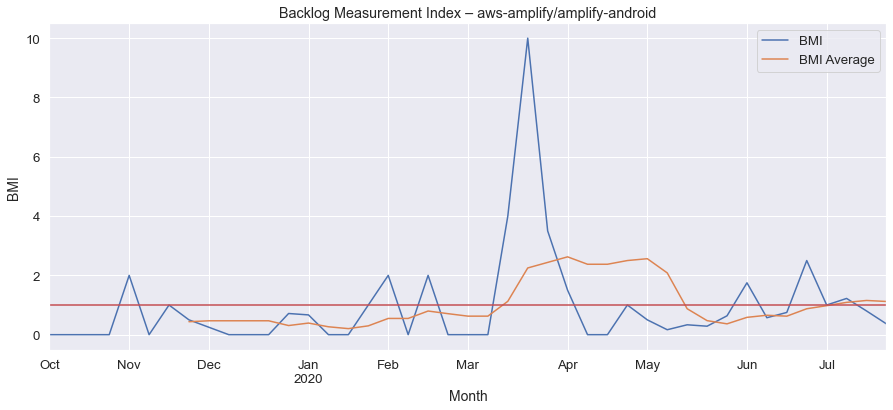

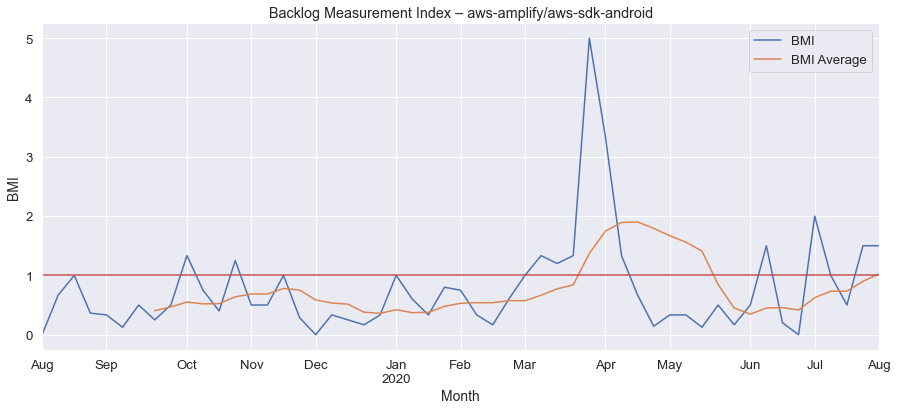

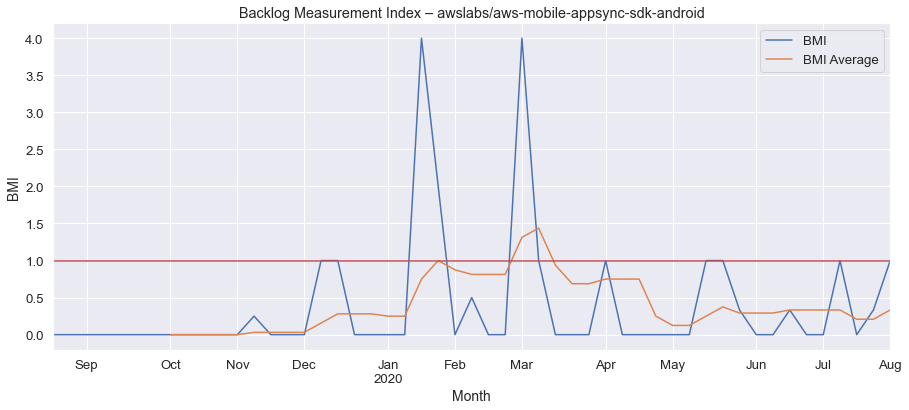

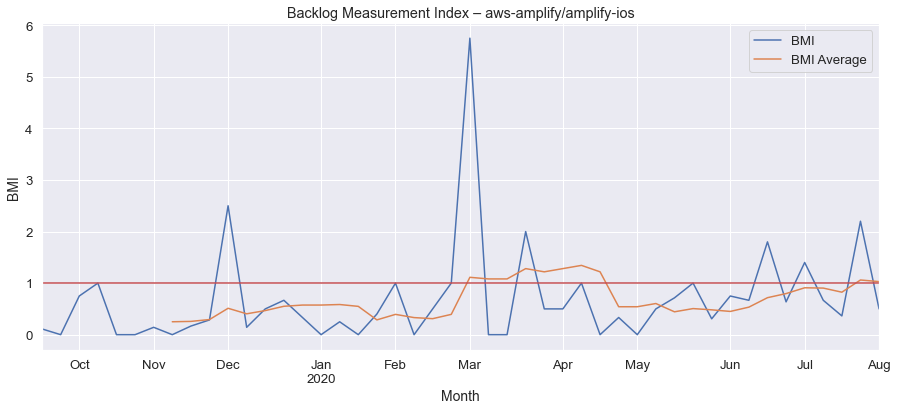

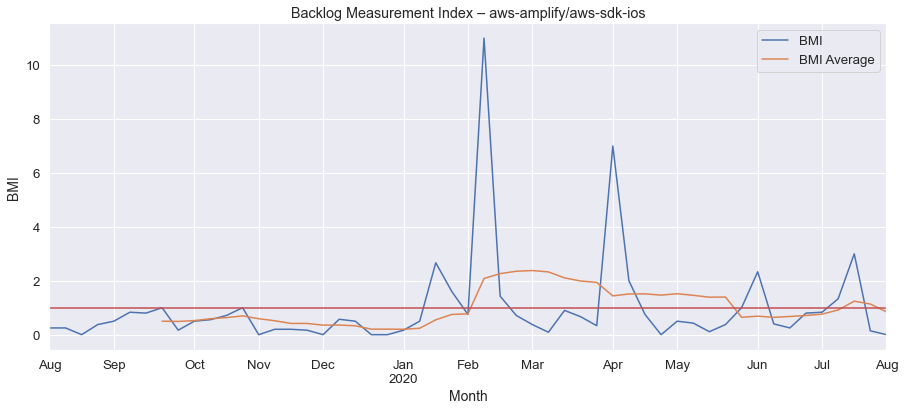

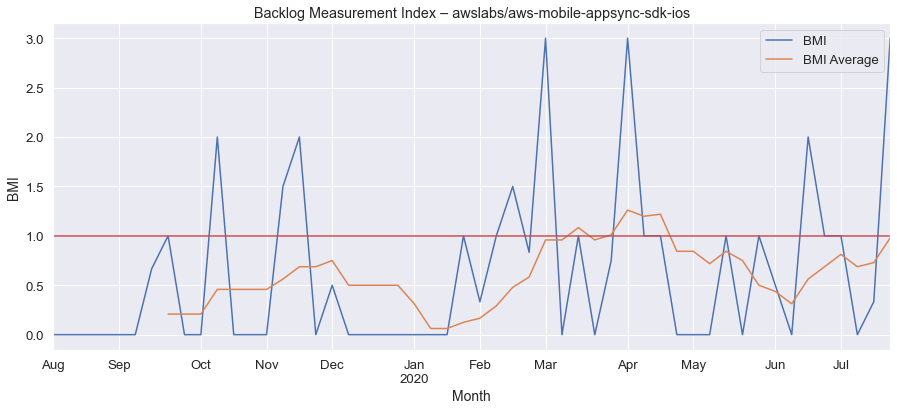

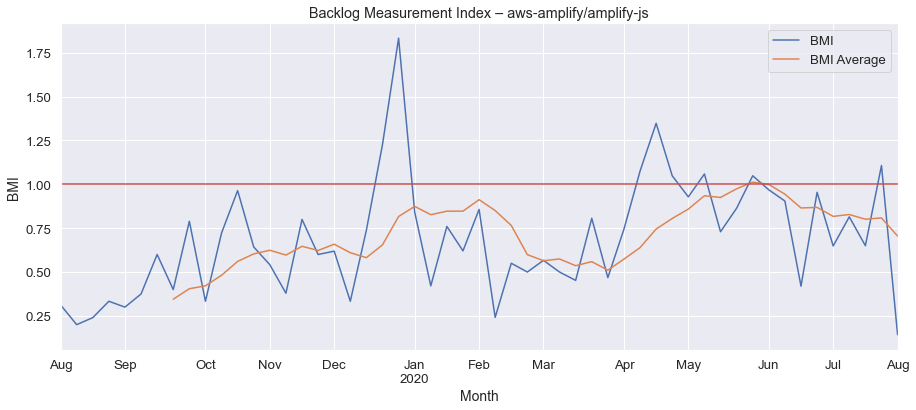

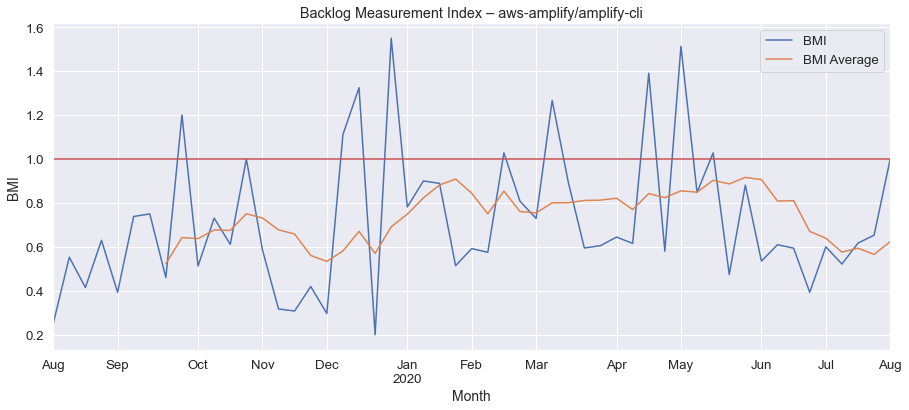

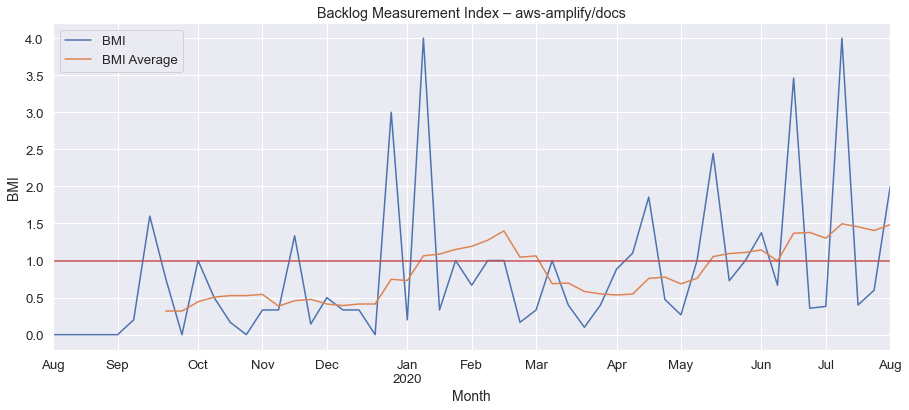

In [9]:
# Backlog Management Index

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)
%matplotlib inline

for repo_name, df in repos.items(): 
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 

    opened = df.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = df.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})

    both['Closed'] = both['Closed'].fillna(0)
    both['Opened'] = both['Opened'].fillna(0)
    both['BMI'] = both['Closed'] / both['Opened']
    both['BMI'] = both['BMI'].replace([np.inf, -np.inf], np.nan)
    both['BMI'] = both['BMI'].fillna(both['Closed'])

    both['BMI Average'] = both['BMI'].rolling(window=8).mean()

    ax = both[['BMI', 'BMI Average']].plot(kind='line', figsize=(15, 6), legend=True)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('BMI', fontsize=14)
    
    ax.set(title=f'Backlog Measurement Index – {repo_name}')
    
    plt.axhline(y=1.0, color='r', linestyle='-')
    plt.show()

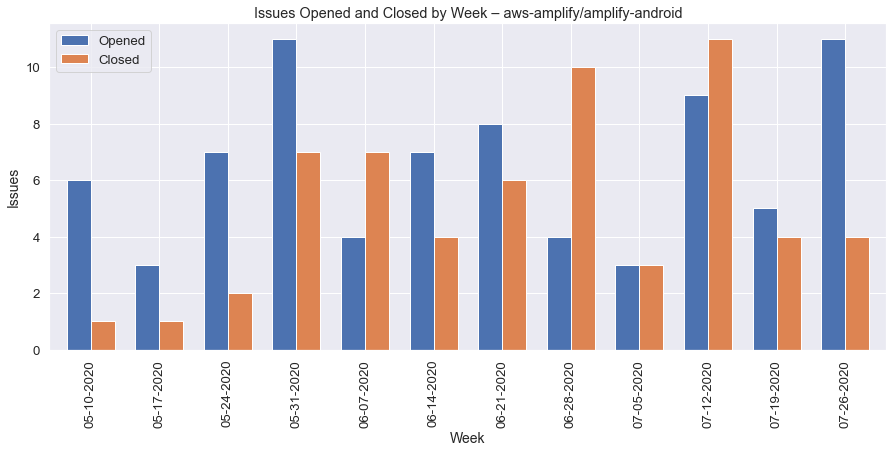

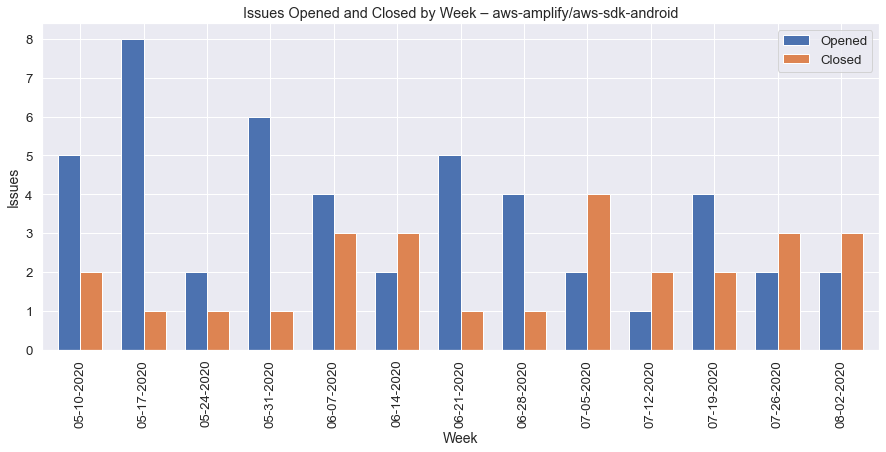

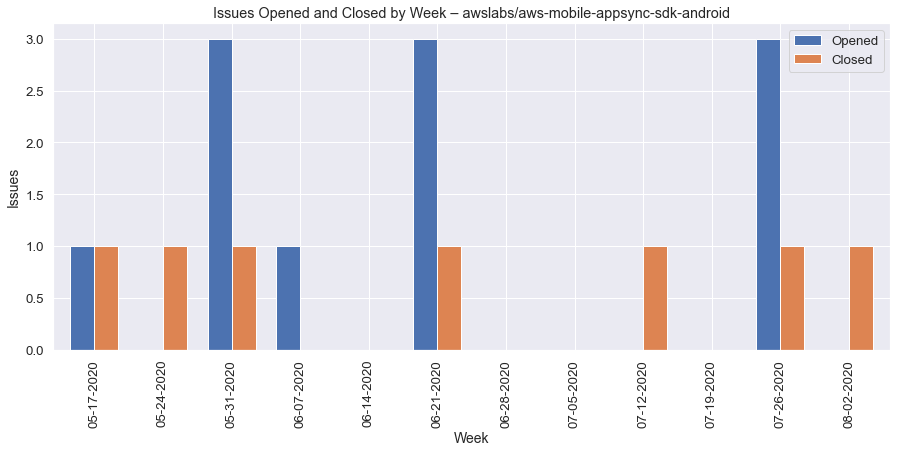

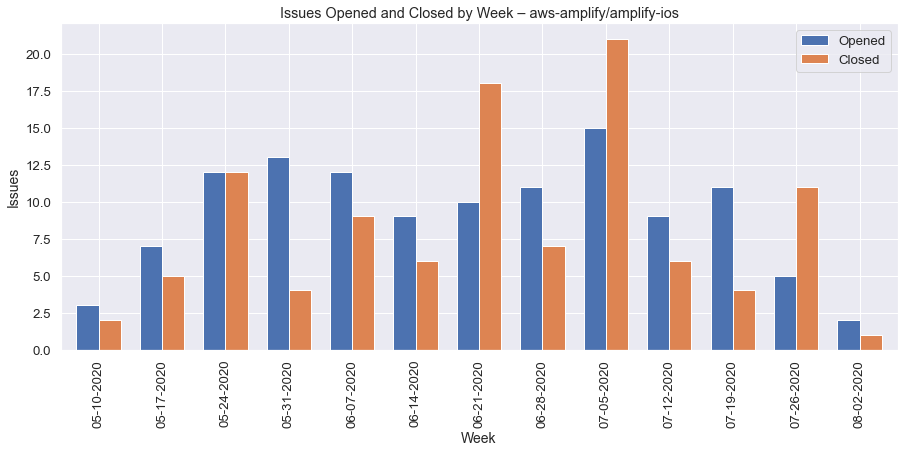

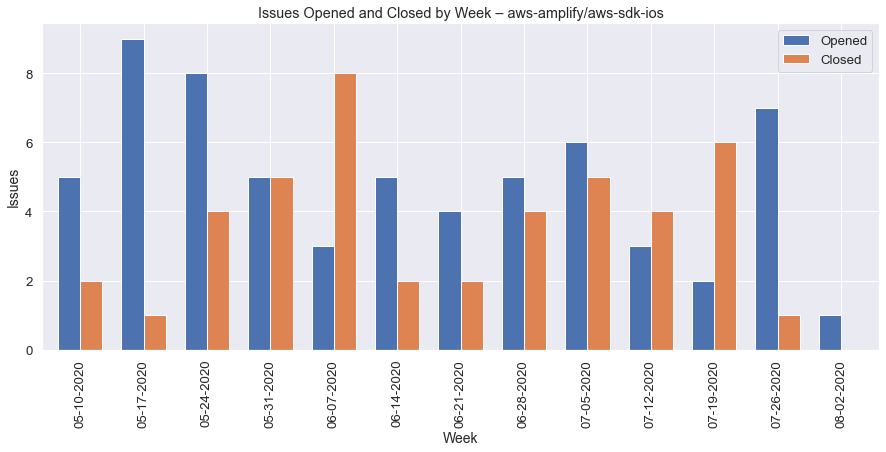

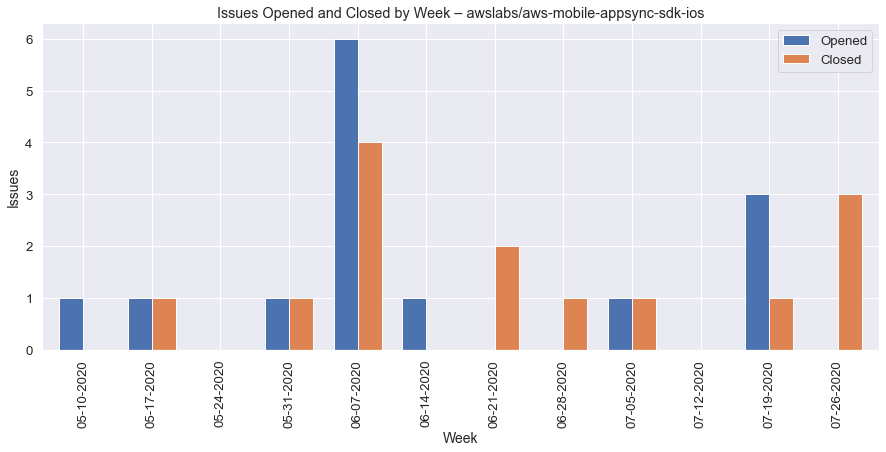

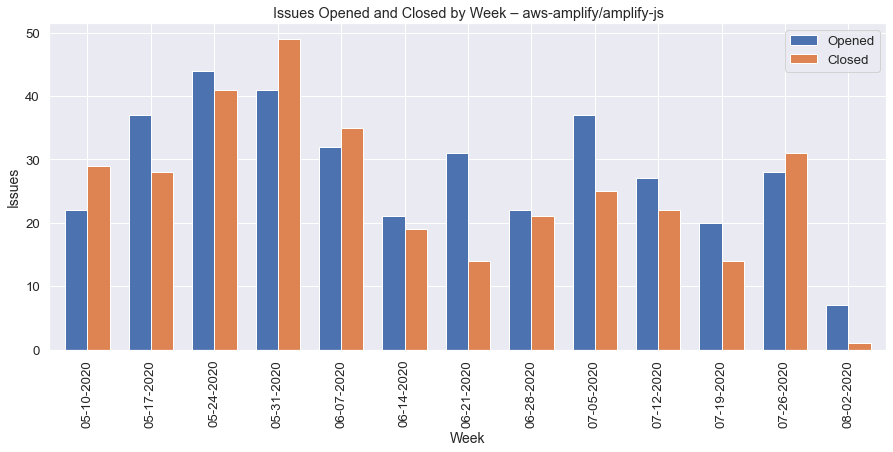

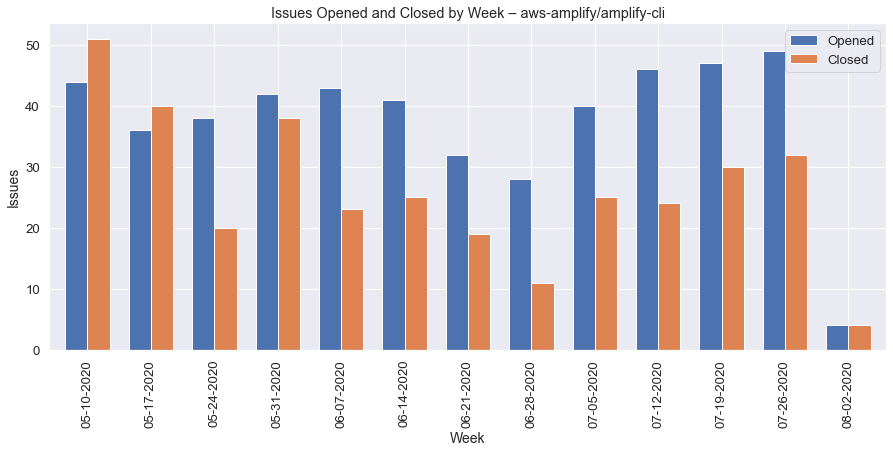

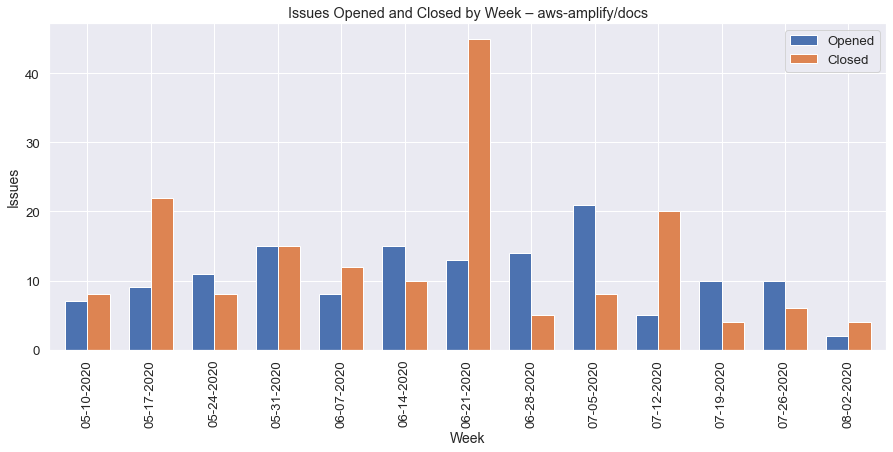

In [10]:
# Issues Opened and Closed by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)
%matplotlib inline

for repo_name, df in repos.items():
    opened = df.loc[(df.created_at > now - timedelta(weeks=12))] 
    closed = df.loc[(df.closed_at > now - timedelta(weeks=12))] 
    
    opened = opened.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = closed.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})
    ax = both[['Opened','Closed']].plot(kind='bar', width=0.7, figsize=(15, 6), legend=True)

    ax.set_xlabel('Week', fontsize=14)
    ax.set_ylabel('Issues', fontsize=14)
    ax.set_xticklabels(both.index.strftime('%m-%d-%Y'))
    ax.set(title=f'Issues Opened and Closed by Week – {repo_name}')
    
    plt.show()

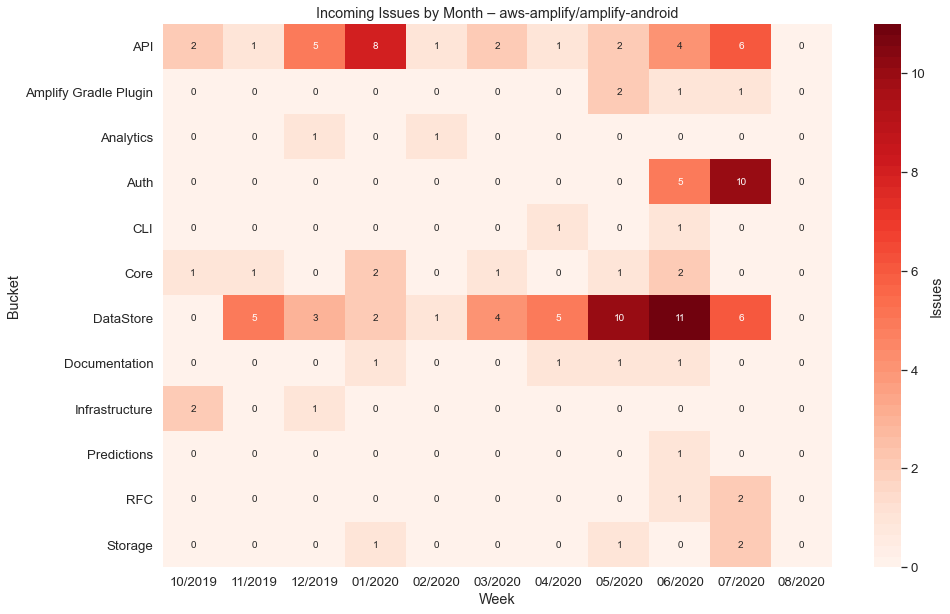

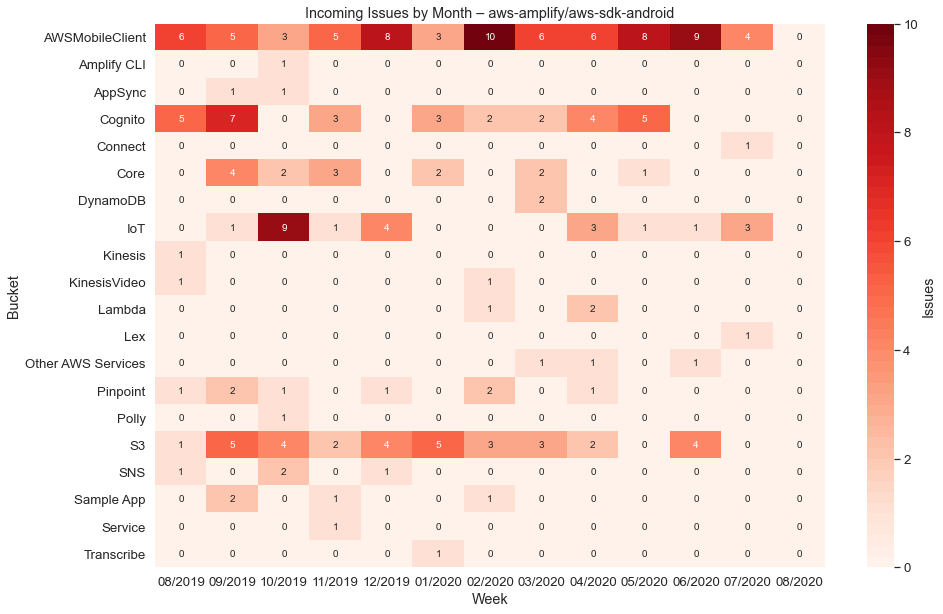

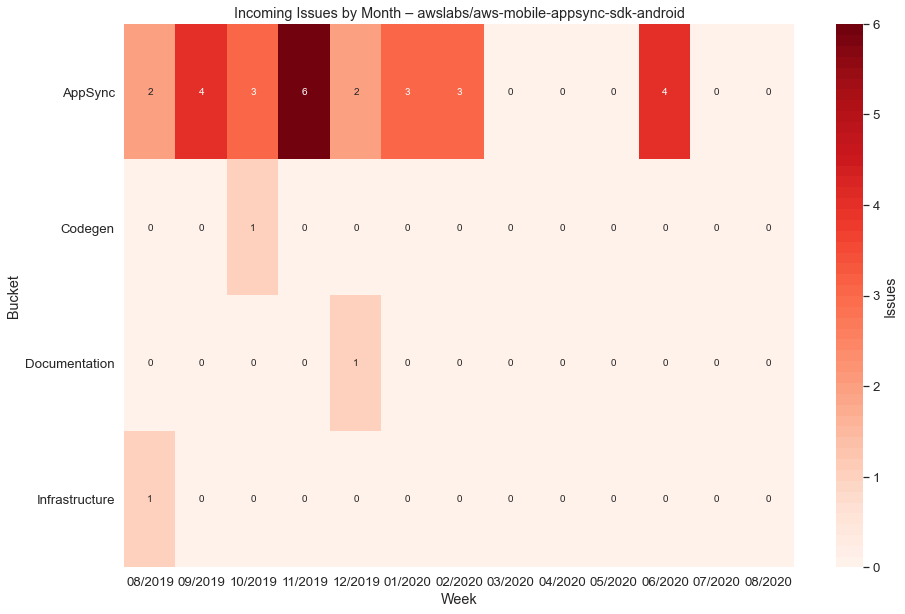

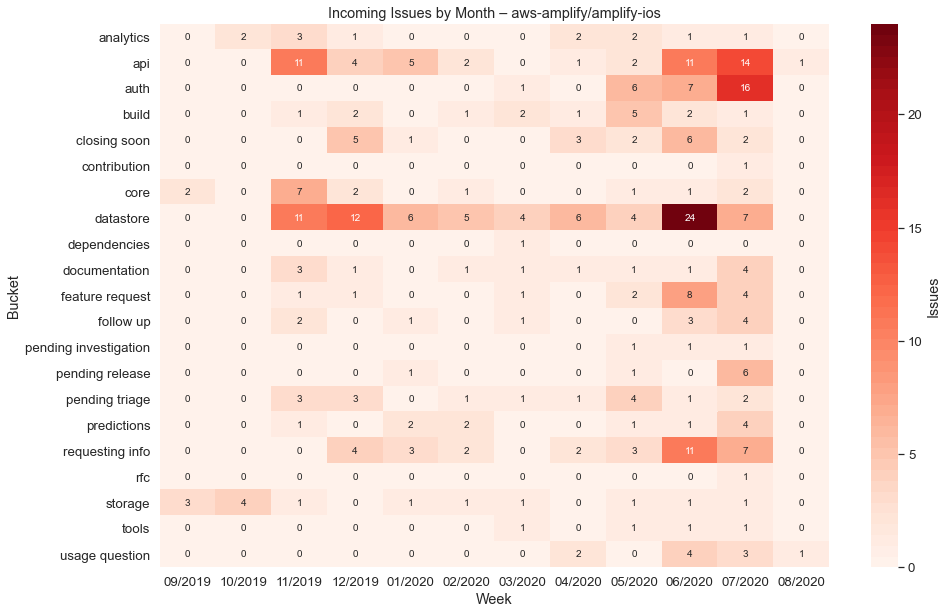

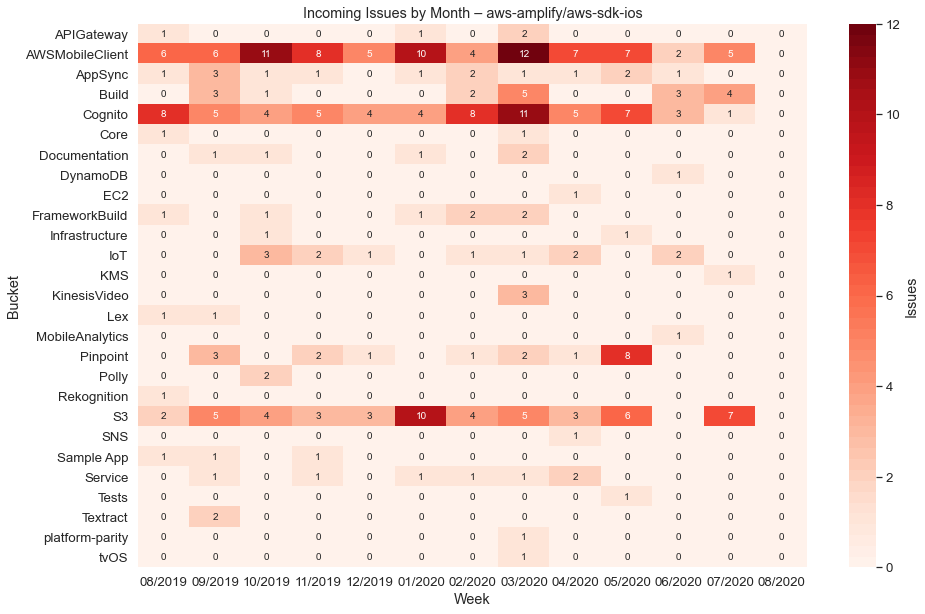

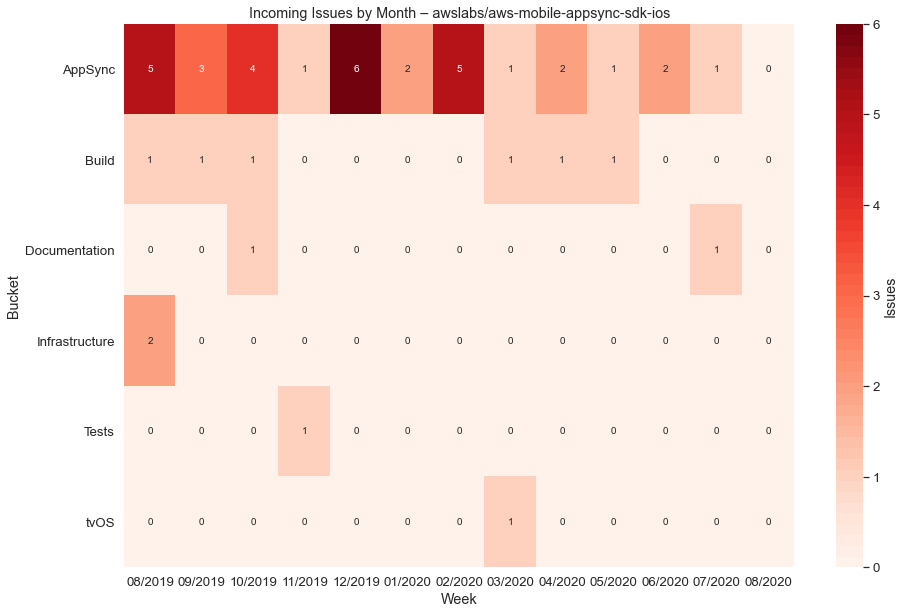

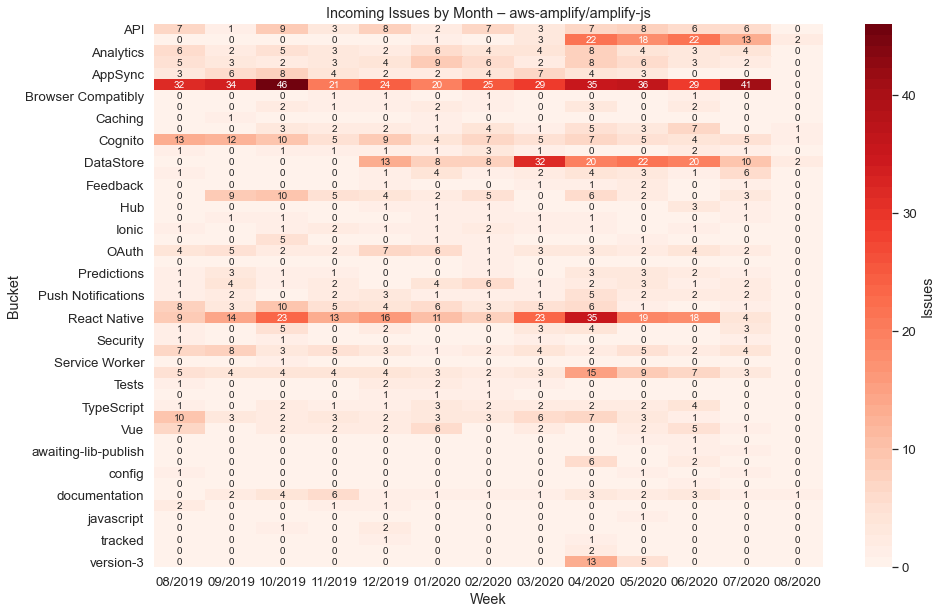

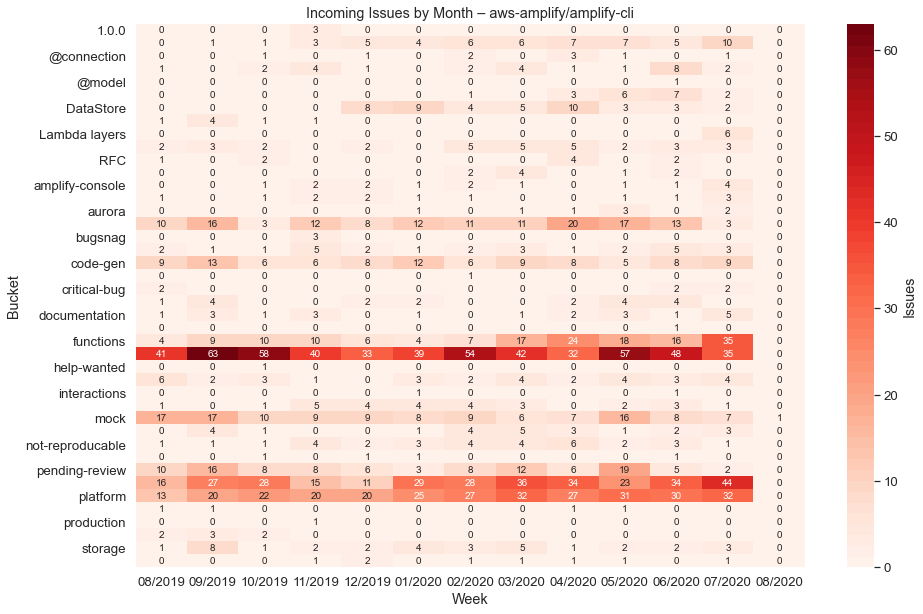

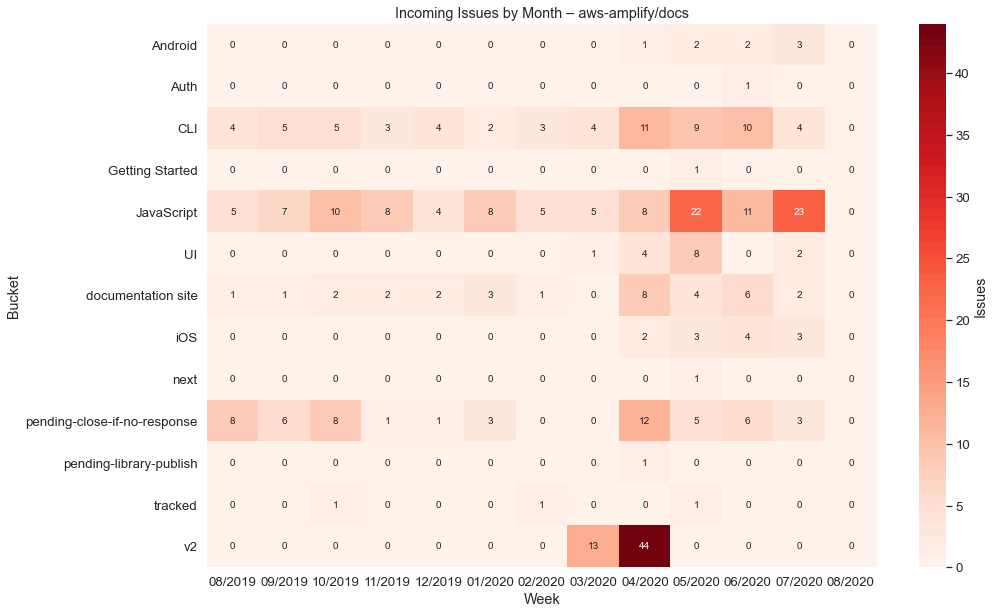

In [11]:
# Incoming Issues by Month

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=12), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():    
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.label.apply(lambda l: l not in omit_labels)]
    df = df.pivot(index='created_at', columns='label', values='created_at')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('M', label='right').count().transpose()
    
    if (len(df)):
        plt.subplots(figsize=(15, 10))

        dates = df.columns.strftime('%m/%Y').unique()
        ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds", 50), fmt='.0f', annot=True,
                         cbar_kws={'label': 'Issues'})

        ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Issues by Month – {repo_name}')
        plt.yticks(rotation=0)
        plt.show()

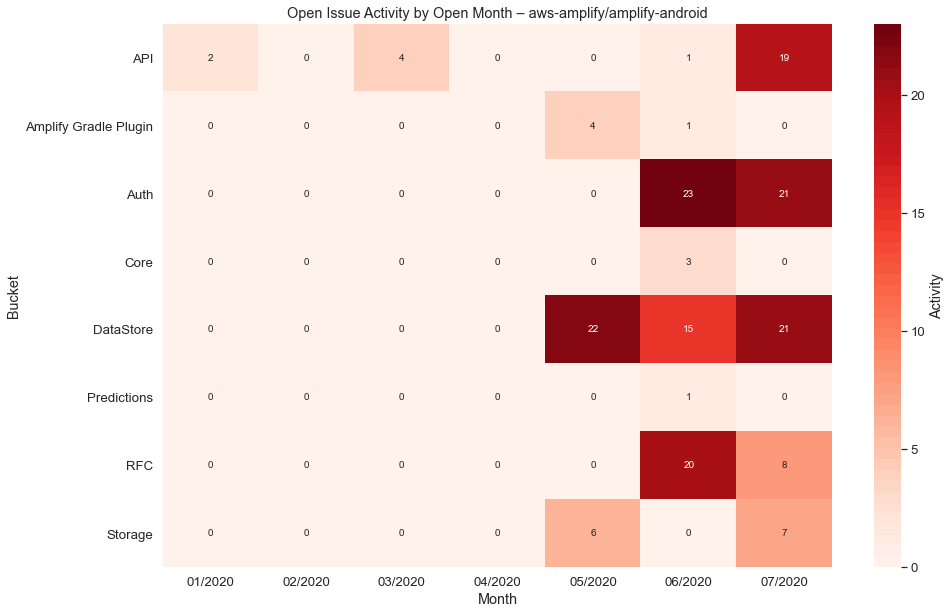

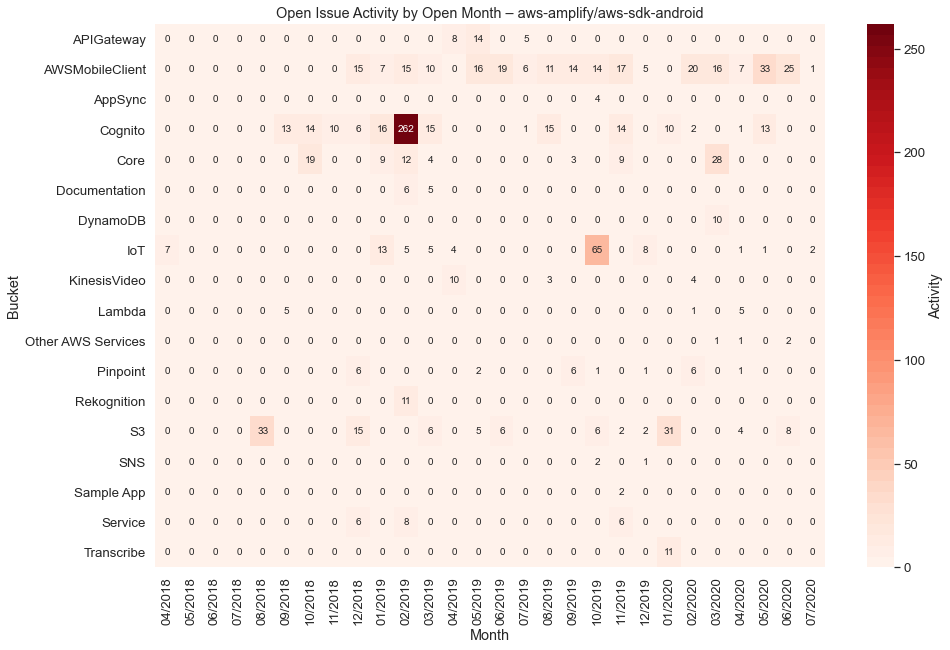

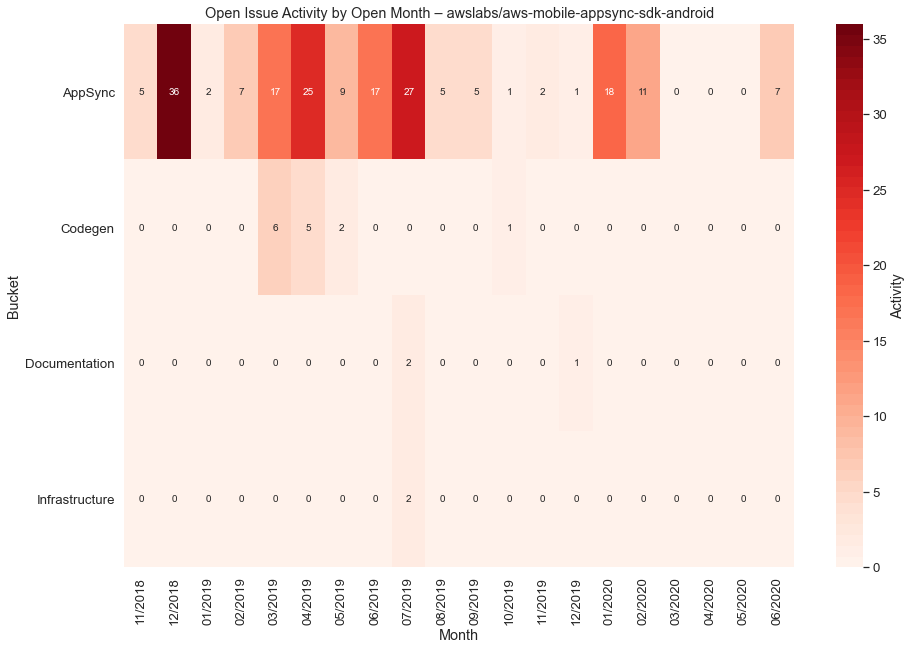

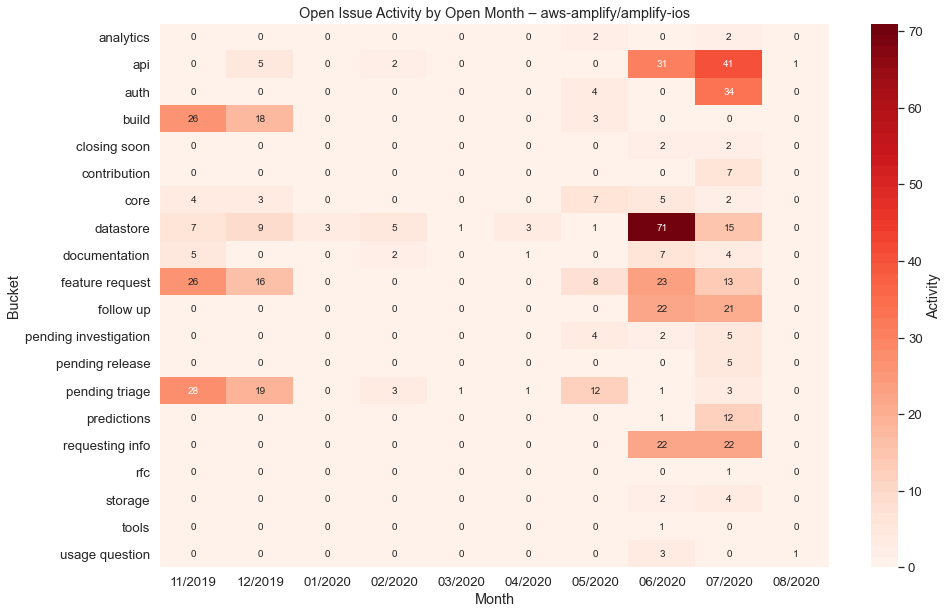

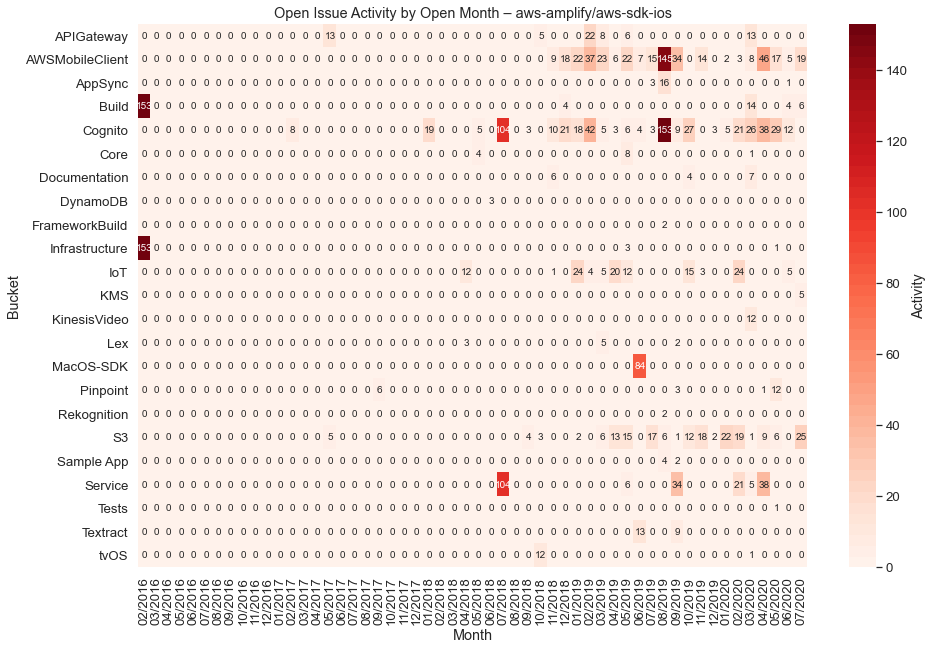

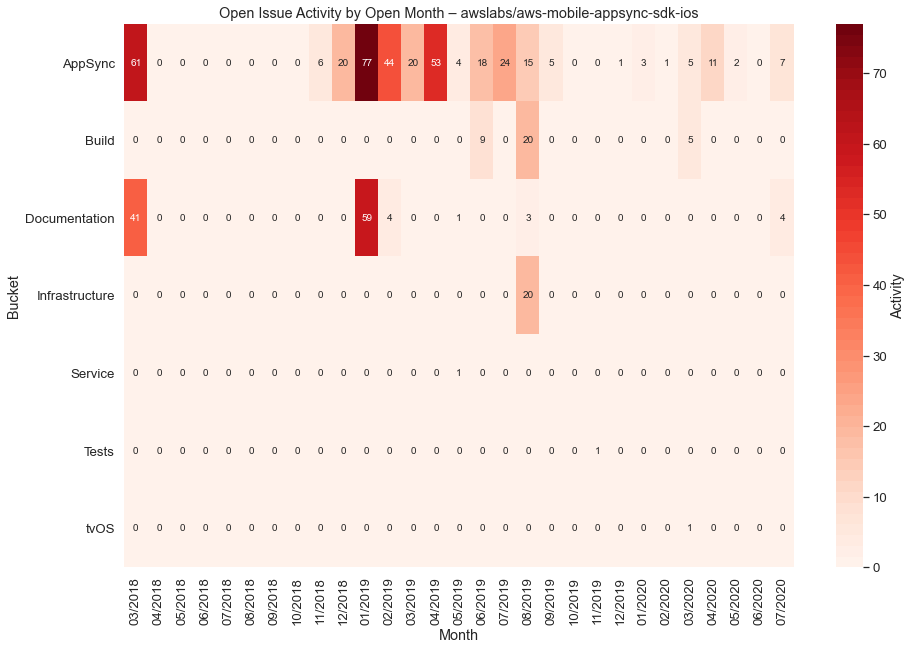

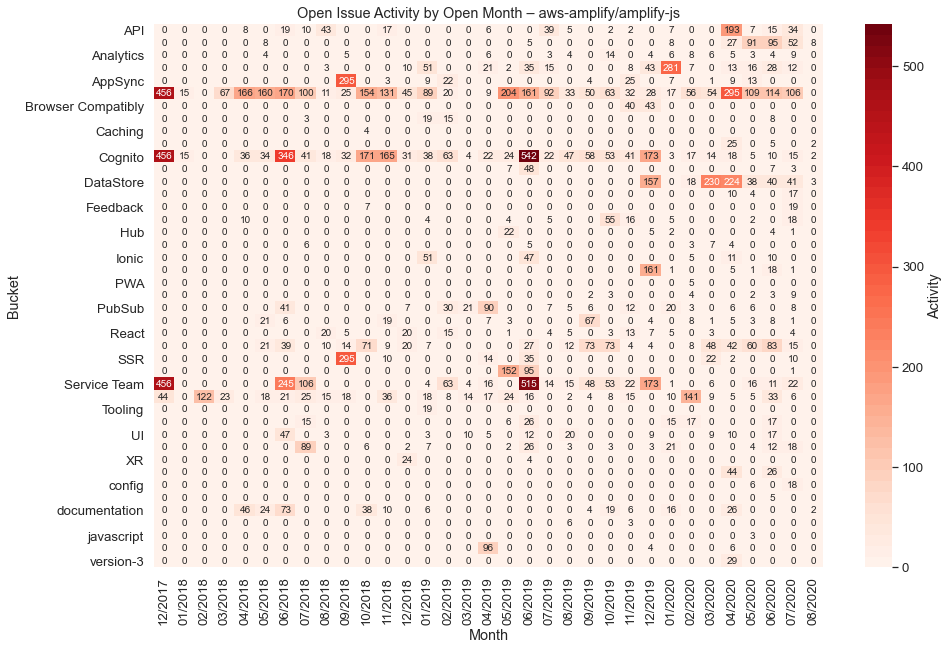

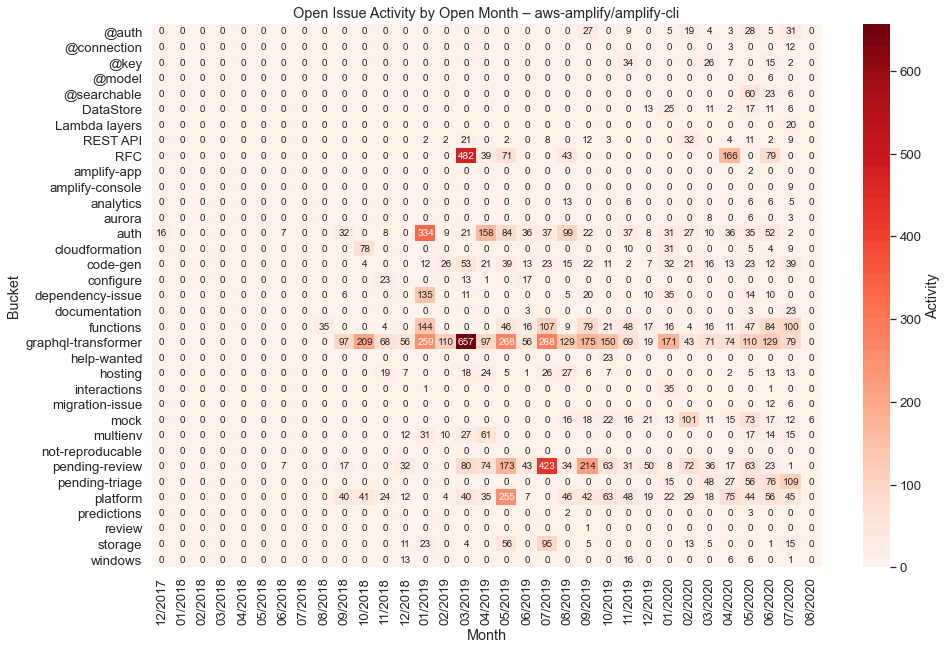

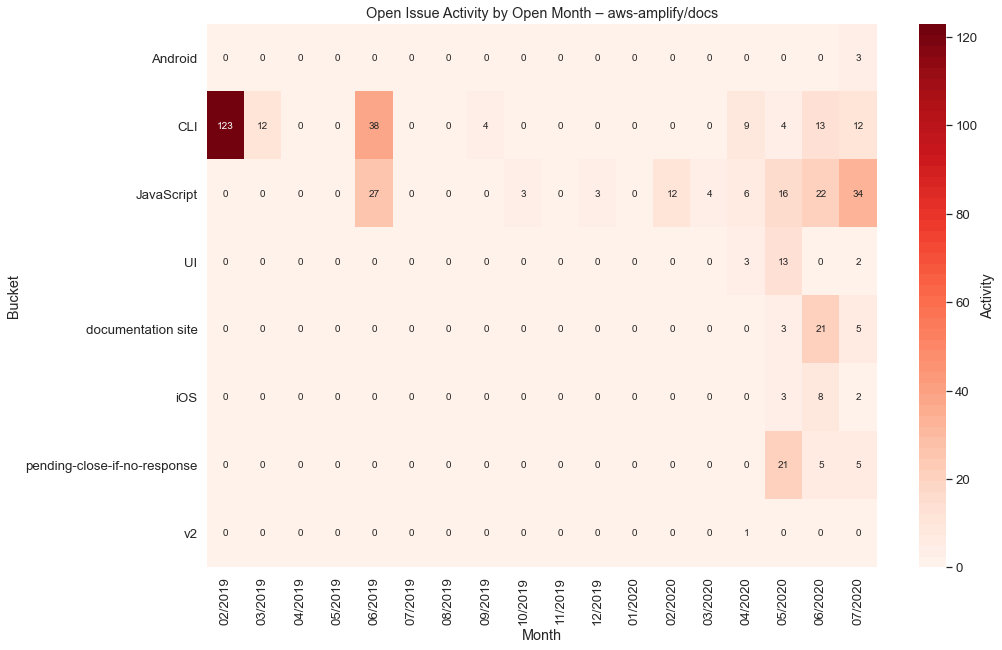

In [12]:
# Open Issues Activity by Open Month

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 10))
    
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.label.apply(lambda l: l not in omit_labels)]
    df = df.pivot(index='created_at', columns='label', values='score')
    df = df.resample('M', label='right').sum().transpose()

    dates = df.columns.strftime('%m/%Y')
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette('Reds', 50), annot=True, fmt='.0f',
                     cbar_kws={'label': 'Activity'})
    ax.set(xlabel='Month', ylabel='Bucket', title=f'Open Issue Activity by Open Month – {repo_name}')

    plt.yticks(rotation=0)
    plt.show()

In [13]:
from datetime import datetime
from IPython.display import display, HTML

total = (datetime.now() - start).seconds
minutes, seconds = divmod(total, 60)

if minutes:
    display(HTML(f'<em>Report generation took {minutes}min, {seconds}sec'))
else:
    display(HTML(f'<em>Report generation took {seconds}sec'))